In [1]:
import pooch

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_basic_synthesis.ipynb`**!

:::

(ps-basic-synth)=
# Using the Portilla-Simoncelli model in plenoptic

The original {cite:alp}`Portilla2000-param-textur` publication was accompanied by [matlab code](https://github.com/LabForComputationalVision/textureSynth/) which computed the model's output ("analysis") and generated new metamers for the model ("synthesis"). This code was hyper-specific for the Portilla-Simoncelli texture model and would not work with any other models.

`plenoptic` includes an implementation of the original model which is compatible with our gradient-based synthesis methods. In this notebook, we will introduce the {class}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli` class and how to use it with the {class}`~plenoptic.synthesize.metamer.Metamer` class to synthesize model metamers.

:::{admonition} Reproducing the metamers in this notebook
:class: warning dropdown

Due to pytorch's limitations, we [cannot guarantee perfect reproducibility](reproduce).
However, we've found the setup shown in this notebook works reliably across different images and produce good metamers efficiently.

If you use follow these basic steps and **are not** able to successfully synthesize a good `PortillaSimoncelli` <!-- skip-lint -->  model metamer, please post on our [discussion board](https://github.com/plenoptic-org/plenoptic/discussions/) and we'll try to help!

See [](ps-optimization) for more information about the specific decisions taken around optimization, including what "good" means.

:::

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

## A quick reminder of what metamers are and why we are calculating them

Model metamers are images with different pixel values but (near-)identical model outputs. The primary reason that the original {cite:alp}`Portilla2000-param-textur` paper developed the metamer procedure was to assess whether the model's understanding of textures matches that of humans. While developing the model, the authors originally evaluated it by performing texture classification on a then-standard dataset (i.e., "is this a piece of fur or a patch of grass?"). The model aced the test, with 100% accuracy. After an initial moment of elation, the authors decided to double-check and performed the same evaluation with a far simpler model, which used the steerable pyramid to compute oriented energy (the first stage of the model described here). That model also classified the textures with 100% accuracy. The authors interpreted this as their evaluation being too easy, and sought a method that would allow them to determine whether their model better matched human texture perception.

In the metamer paradigm they eventually arrived at, the authors generated sets of model metamers. They then evaluated whether these images belonged to the same texture class: does this model metamer of a basket also look like a basket, or does it look like something else? Importantly, they were not evaluating whether the images were *indistinguishable*, but whether they belonged to the same texture family. This paradigm thus tests whether the model is capturing important information about how humans understand and group textures.

## Plenoptic's PortillaSimoncelli class

Before synthesizing a model metamer, let's spend a bit of time with the {class}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli` class. First, let's grab a texture image:

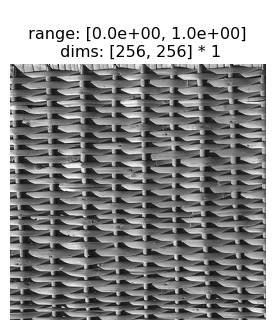

In [3]:
img = po.tools.load_images(IMG_PATH / "fig4a.jpg")
po.imshow(img);

Now let's create an instance of the PortillaSimoncelli model with the following parameters:

- `n_scales=4`, The number of scales in the steerable pyramid underlying the model.
- `n_orientations=3`, The number of orientations in the steerable pyramid.
- `spatial_corr_width=9`, The size of the window used to calculate the correlations across steerable pyramid bands.

Running the model on an image will return a tensor of numbers summarizing the "texturiness" of that image, which we refer to as the model's representation. These statistics are measurements of different properties that the authors considered relevant to a texture's appearance (where a texture is defined above), and capture some of the repeating properties of these types of images.

In [4]:
model = po.simul.PortillaSimoncelli(
    img.shape[-2:], n_scales=4, n_orientations=3, spatial_corr_width=9
)
representation = model(img)
print(
    f"The texture model has {representation.shape[-1]} statistics. "
    "Here's the first several:"
)
print(representation[..., :10])

The texture model has 807 statistics. Here's the first several:
tensor([[[ 4.3503e-01,  4.0737e-02,  1.6215e-01,  2.2822e+00,  0.0000e+00,
           9.9608e-01,  1.4031e-02, -8.3651e-02, -4.1651e-01,  2.0114e-03]]])


The model's representation consists of several different classes of statistics. We will explore these statistics and how they relate to visual textures in more detail in the [](ps-model-stats) notebook, but the class has two methods which can help you better understand the representation:

- {func}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli.convert_to_dict` will turn the representation tensor into a dictionary with informative keys:

In [5]:
rep_dict = model.convert_to_dict(representation)
for k, v in rep_dict.items():
    print(k, v.shape)

pixel_statistics torch.Size([1, 1, 6])
auto_correlation_magnitude torch.Size([1, 1, 9, 9, 3, 4])
skew_reconstructed torch.Size([1, 1, 5])
kurtosis_reconstructed torch.Size([1, 1, 5])
auto_correlation_reconstructed torch.Size([1, 1, 9, 9, 5])
std_reconstructed torch.Size([1, 1, 5])
cross_orientation_correlation_magnitude torch.Size([1, 1, 3, 3, 4])
magnitude_std torch.Size([1, 1, 3, 4])
cross_scale_correlation_magnitude torch.Size([1, 1, 3, 3, 3])
cross_scale_correlation_real torch.Size([1, 1, 3, 6, 3])
var_highpass_residual torch.Size([1, 1, 1])


The statistics have also been reshaped so that e.g., the `auto_correlation_magnitude` representation has shape `(batch, channel, spatial_corr_width, spatial_corr_width, n_orientations, n_scales)`, which might make understanding the values easier.

- {func}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli.plot_representation` will plot a summarized version of the representation tensor:

(<Figure size 864x360 with 8 Axes>,
 [<Axes: title={'center': 'pixels+var_highpass'}>,
  <Axes: title={'center': 'std+skew+kurtosis recon'}>,
  <Axes: title={'center': 'magnitude_std'}>,
  <Axes: title={'center': 'auto_correlation_reconstructed'}>,
  <Axes: title={'center': 'auto_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_orientation_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_scale_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_scale_correlation_real'}>])

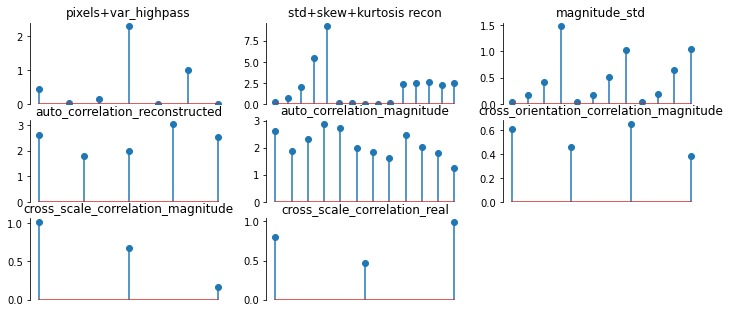

In [6]:
model.plot_representation(representation)

This plot will be also useful when investigating metamer synthesis progress, so that we can see which statistics are matched and which still differ.

When the model representation of two images match, the model considers the two images identical and we say that those two images are model metamers. Synthesizing a novel image that matches the representation of some arbitrary input is the goal of the {class}`~plenoptic.synthesize.metamer.Metamer` class, as described in the next section.

## Synthesizing Portilla-Simoncelli Texture Model Metamers

Synthesizing Portilla-Simoncelli model metamers require some additional options compared to the [basic Metamer usage](metamer-nb). This section will demonstrate how to synthesize a model metamer for this wicker basket texture:

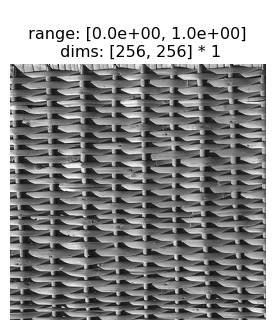

In [7]:
po.imshow(img);

The following settings seem to reliably find good metamers for this model. Here, we just give a brief overview of these options; see the [](ps-optimization) notebook for more information.

- `max_iter=100` puts an upper bound (of 100) on the number of iterations that the optimization will run.
- `loss_function` <!-- skip-lint --> specifies the loss function to use. Here, we use a loss that we know works well for this model, which reweights some of the representation to find a better solution.
- `optimizer` <!-- skip-lint --> / `optimizer_kwargs` specifies the torch optimizer to use and its keyword arguments. Here, we use {class}`~torch.optim.LBFGS`, which uses an estimate of the Hessian matrix (which contains all second-order partial derivatives) to find the best solution.

This process takes about 4 minutes on my laptop without a GPU. How long it will take depends on your system and, in particular, whether you have a GPU.

In [8]:
# send image and PS model to GPU, if available. then Metamer will also
# use GPU
img = img.to(DEVICE)
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Now we can visualize the output of the synthesis optimization. First we compare the *Target image* and the *Synthesized image* side-by-side. We can see that they appear perceptually similar --- that is, for this texture image, matching the Portilla-Simoncelli texture stats gives you an image that the human visual system *also* considers similar.

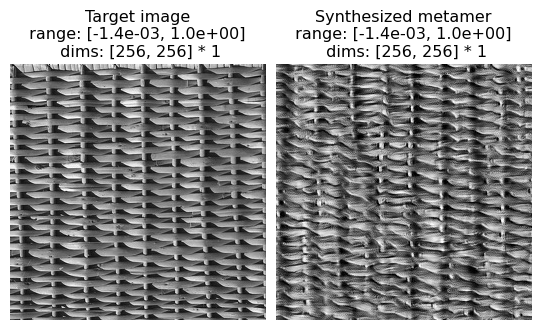

In [9]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized metamer"],
    vrange="auto1",
);

We can also use plenoptic's {func}`~plenoptic.synthesize.metamer.plot_synthesis_status` method to see how things are going. The image on the left shows the metamer at this moment in synthesis, while the center plot shows the loss over time, with the red dot pointing out the current loss, and the rightmost plot shows the representation error (i.e., the {func}`~plenoptic.simulate.models.portilla_simoncelli.PortillaSimoncelli.plot_representation` figure from above, but for `model(target image) - model(synthesized image)`).

We can see the synthesized texture on the leftmost plot. The overall synthesis error decreases over the synthesis iterations (subplot 2).  The remaining plots show us the error broken out by the different texture statistics; see [](ps-model-stats) to better understand them.

(<Figure size 2131.2x360 with 11 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 4, 5, 6, 7, 8, 9, 10, 2],
  'misc': []})

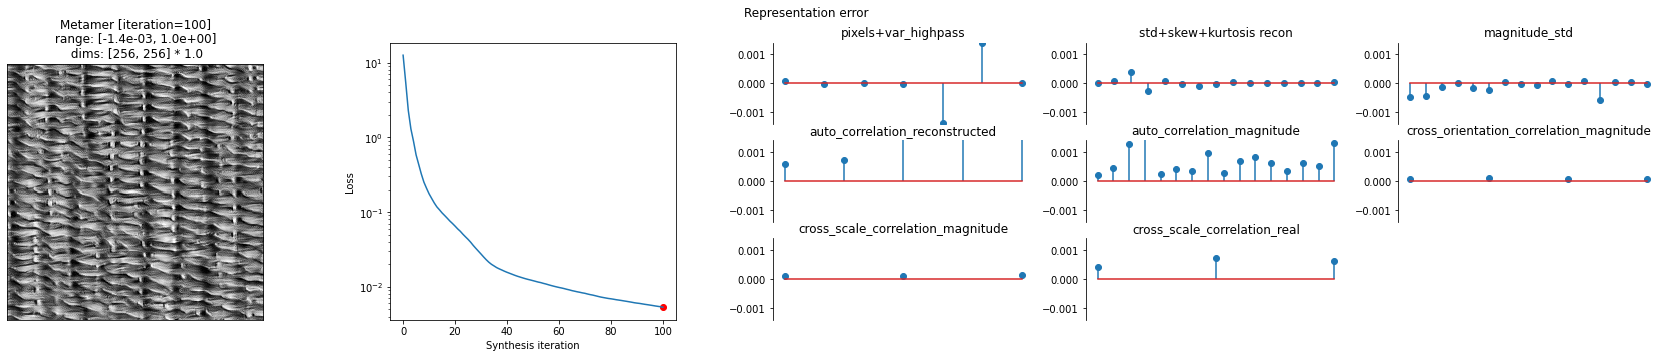

In [10]:
po.synth.metamer.plot_synthesis_status(
    met, width_ratios={"plot_representation_error": 3.1}
)

## Further reading

To see more texture model metamers with different types of images, see the [](ps-examples) notebook.

Alternatively, to learn more:
- about the different components of the model's representation, read the [](ps-model-stats) notebook.
- about the optimization choices taken above, read the [](ps-optimization) notebook.